In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

In [2]:
data = pd.read_excel('/Users/rachael/Downloads/train_df_labelled.xlsx')
#the data verified by the third person will be used as the train set finally
file =  data[['content','stance']]
file['stance'].value_counts()
label_stance= file['stance'].value_counts()
label_proportions_stance= file['stance'].value_counts(normalize=True)
print("Counts of each label_stance:")
print(label_stance)
print("\nProportions of each label_stance:")
print(label_proportions_stance)

Counts of each label_stance:
stance
Aganist    186
Neither    140
Support     82
Name: count, dtype: int64

Proportions of each label_stance:
stance
Aganist    0.455882
Neither    0.343137
Support    0.200980
Name: proportion, dtype: float64


In [3]:
import re
def remove_urls(text):
    # 定义URL的正则表达式
    url_pattern = r'https?://\S+|www\.\S+'
    # 使用re.sub()函数替换URL为空字符串
    no_url_text = re.sub(url_pattern, '', text)
    return no_url_text

def clean_text(text):
    # Remove anything that is not a letter or space
    clean_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Optional: Convert text to lower case
    clean_text = clean_text.lower()
    return clean_text

In [4]:
file['content'] = file['content'].apply(remove_urls) 
file['content'] = file['content'].apply(clean_text) 
file['stance'] = file['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
y = file['stance']
X = file['content']

/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10065/271919431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(remove_urls)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10065/271919431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['content'] = file['content'].apply(clean_text)
/var/folders/vq/5p2k6x290wzfc5dzz5xm78bm0000gp/T/ipykernel_10065/271919431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [5]:
from gensim.models import KeyedVectors
import spacy
nlp = spacy.load("nl_core_news_sm")
#tokenize
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

#load pre-trained word2vec embedding 
model_path = '/Users/rachael/Downloads/39/model.bin'
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)
vector_size = word_vectors.vector_size #dimension of embedding 100

# word embedding mapping and convert sentences to the average of vectors
def sentence_to_avg_vec(tokens, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for token in tokens:
        if token in model:
            vec += model[token]
            count += 1
    if count != 0:
        vec /= count
    return vec

In [9]:
# Initialize parameters
best_score = 0
best_params = {}

#hyperparameter range
param_dist = {
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'saga'],  # Solvers that support multinomial loss
    'max_iter': [20000, 30000,40000],  # Maximum number of iterations
}

test_scores = []
best_params_list = []
f1_scores = []
balanced_accuracies = []

In [10]:
# Stratified K-fold for maintaining label distribution, shuffle=True ensures different data splits in each iteration
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced')
randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]    # 确保传递字符串数据
    trainX = trainX.astype(str)
    testX = testX.astype(str)

    # 进行tokenize
    X_train_tokenized = trainX.apply(tokenize)
    X_test_tokenized = testX.apply(tokenize)

     #map word embedding to tokenized train and test data
    X_train_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_train_tokenized])
    X_test_embeddings= np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_test_tokenized])

#define model
    lr = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced')
    randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

    # 拟合随机搜索
    randomized_search.fit(X_train_embeddings, trainy)

    # 获取最佳模型
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # 在测试集上进行预测
    test_predictions = best_model.predict(X_test_embeddings)
    balanced_acc = f1_score(testy, test_predictions,average='macro')

    # 存储结果
    balanced_accuracies.append(balanced_acc)
    best_params_list.append(best_params)

    print(f"Fold Balanced Accuracy: {balanced_acc}")
    print(f"Best parameters: {best_params}")

# 汇总结果

mean_balanced_acc = np.mean(balanced_accuracies)
std_balanced_acc = np.std(balanced_accuracies)

print(f"Mean Balanced Accuracy: {mean_balanced_acc}")
print(f"Standard deviation of Balanced Accuracies: {std_balanced_acc}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold Balanced Accuracy: 0.48073411878186584
Best parameters: {'solver': 'newton-cg', 'max_iter': 40000, 'C': 0.23357214690901212}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold Balanced Accuracy: 0.5803601298006155
Best parameters: {'solver': 'saga', 'max_iter': 40000, 'C': 29.763514416313132}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold Balanced Accuracy: 0.41962410171365394
Best parameters: {'solver': 'saga', 'max_iter': 30000, 'C': 11.288378916846883}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold Balanced Accuracy: 0.49442804293550563
Best parameters: {'solver': 'newton-cg', 'max_iter': 30000, 'C': 1.623776739188721}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold Balanced Accuracy: 0.4876190476190477
Best parameters: {'solver': 'lbfgs', 'max_iter': 20000, 'C': 4.281332398719396}
Mean Balanced Accuracy: 0.4925530881701377
Standard devia

In [11]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'C': 0.23357214690901212, 'max_iter': 40000, 'solver': 'newton-cg'}


In [6]:
most_common_params = {'solver': 'saga', 'max_iter': 40000, 'C': 29.763514416313132}

In [7]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, 100) for tokens in X_tokenized])
final_model = LogisticRegression(multi_class='multinomial', random_state=42, **most_common_params,class_weight='balanced')
final_model.fit(X_embeddings, y)

LogisticRegression(C=29.763514416313132, class_weight='balanced',
                   max_iter=40000, multi_class='multinomial', random_state=42,
                   solver='saga')

In [8]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#process test data 
test = test[['content','stance']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['stance'] = test['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in test_tokenized])

#predict 
test_predictions = final_model.predict(test_embedding)
conf_matrix = confusion_matrix(test['stance'], test_predictions)
class_report = classification_report(test['stance'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.27      0.41      0.32        76
           1       0.54      0.43      0.48       191
           2       0.49      0.48      0.48       140

    accuracy                           0.44       407
   macro avg       0.43      0.44      0.43       407
weighted avg       0.47      0.44      0.45       407



In [10]:

test['stance'].value_counts()
label_stance_test= test['stance'].value_counts()
label_proportions_stance_test= test['stance'].value_counts(normalize=True)
print("Counts of each label_stance:")
print(label_stance_test)
print("\nProportions of each label_stance:")
print(label_proportions_stance_test)

Counts of each label_stance:
stance
1    191
2    140
0     76
Name: count, dtype: int64

Proportions of each label_stance:
stance
1    0.469287
2    0.343980
0    0.186732
Name: proportion, dtype: float64


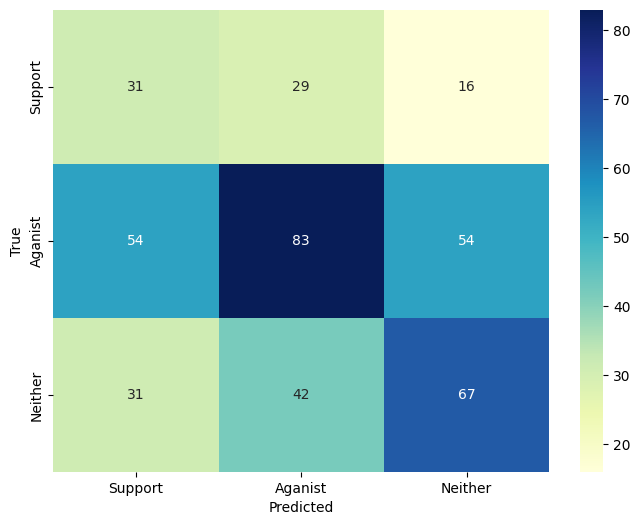

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Support', 'Aganist', 'Neither'], yticklabels=['Support', 'Aganist', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
# Stratified K-fold for maintaining label distribution, shuffle=True ensures different data splits in each iteration
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lr = LogisticRegression(multi_class='multinomial', random_state=42,class_weight='balanced')
randomized_search = RandomizedSearchCV(
        estimator=lr,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings that are sampled
        scoring='f1_macro',
        n_jobs=-1,  # Use all available cores
        cv=inner_cv,
        random_state=42,
        verbose=1
    )

# Loop over each fold
for train_index, test_index in outer_cv.split(X, y):
    trainX, testX = X.iloc[train_index], X.iloc[test_index]
    trainy, testy = y.iloc[train_index], y.iloc[test_index]

    # 将 y_train 和 y_test 转换为 DataFrame
    y_train_df = pd.DataFrame(trainy).reset_index(drop=True)
    y_test_df = pd.DataFrame(testy).reset_index(drop=True)

    # 拼接 X_train 和 y_train 以及 X_test 和 y_test
    train_df = pd.concat([trainX.reset_index(drop=True), y_train_df], axis=1)
    test_df = pd.concat([testX.reset_index(drop=True), y_test_df], axis=1)

    # 标准化处理文本
    train_df['content'] = train_df['content'].apply(lambda x: ' '.join(x.split()))
    sentiment_0 = train_df[train_df['stance'] == 0]
    sentiment_1 = train_df[train_df['stance'] == 1]
    sentiment_2 = train_df[train_df['stance'] == 2]

    # 数据增强
    output_file_path0 = '/Users/rachael/Desktop/data/sentiment_0.txt'
    with open(output_file_path0, 'w', encoding='utf-8') as f:
        for _, row in sentiment_0.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path0,
        '--output', '/Users/rachael/Desktop/data/augmented_train0.txt',
        '--num_aug', '6',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    output_file_path1 = '/Users/rachael/Desktop/data/sentiment_1.txt'
    with open(output_file_path1, 'w', encoding='utf-8') as f:
        for _, row in sentiment_1.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path1,
        '--output', '/Users/rachael/Desktop/data/augmented_train1.txt',
        '--num_aug', '2',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    output_file_path2 = '/Users/rachael/Desktop/data/sentiment_2.txt'
    with open(output_file_path2, 'w', encoding='utf-8') as f:
        for _, row in sentiment_2.iterrows():
            f.write(f"{row['stance']}\t{row['content']}\n")

    subprocess.run([
        'python', '/Users/rachael/Desktop/data/augment.py',
        '--input', output_file_path2,
        '--output', '/Users/rachael/Desktop/data/augmented_train2.txt',
        '--num_aug', '3',
        '--alpha_sr', '0.1',
        '--alpha_rd', '0.1',
        '--alpha_ri', '0.1',
        '--alpha_rs', '0.1'
    ])

    # Load augmented data
    file4 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train0.txt', delimiter='\t', header=None, names=['stance', 'content'])
    file5 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train1.txt', delimiter='\t', header=None, names=['stance', 'content'])
    file6 = pd.read_csv('/Users/rachael/Desktop/data/augmented_train2.txt', delimiter='\t', header=None, names=['stance', 'content'])
    augmented_train = pd.concat([file4, file5, file6])

    #process train data
    augmented_train['content'] = augmented_train['content'].astype(str)
    y_train = augmented_train['stance']
    X_train = augmented_train['content']
    X_train_tokenized = X_train.apply(tokenize)
    X_train_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_train_tokenized])
    #X_train_embeddings = scaler.fit_transform(X_train_embeddings1)

    #prepare test data
    test_df['content'] = test_df['content'].astype(str)
    y_test = test_df['stance']
    X_test = test_df['content']
    X_test_tokenized = X_test.apply(tokenize)
    X_test_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, vector_size) for tokens in X_test_tokenized])

    # Fit Randomized Search
    randomized_search.fit(X_train_embeddings, y_train)

    # Get the best model from Randomized Search
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_

    # Evaluate on the test set
    test_predictions = best_model.predict(X_test_embeddings)
    test_f1_score = f1_score(y_test, test_predictions, average='macro')

    f1_scores.append(test_f1_score)
    best_params_list.append(best_params)

    print(f"Fold F1-score: {test_f1_score}")
    print(f"Best parameters: {best_params}")

# Summarize the results
mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

print(f"Mean F1-score: {mean_f1_score}")
print(f"Standard deviation of F1-scores: {std_f1_score}")
print("Best parameters for each fold:")
for i, params in enumerate(best_params_list):
    print(f"Fold {i + 1}: {params}")

generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=6
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=2
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_2.txt to /Users/rachael/Desktop/data/augmented_train2.txt with num_aug=3
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fold F1-score: 0.33908982296079077
Best parameters: {'solver': 'newton-cg', 'max_iter': 20000, 'C': 1438.44988828766}
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_0.txt to /Users/rachael/Desktop/data/augmented_train0.txt with num_aug=6
generated augmented sentences with eda for /Users/rachael/Desktop/data/sentiment_1.txt to /Users/rachael/Desktop/data/augmented_train1.txt with num_aug=2
generated augmented sentences with eda for /Users

In [8]:
from collections import Counter
best_params_counter = Counter(tuple(sorted(params.items())) for params in best_params_list)
most_common_params = dict(best_params_counter.most_common(1)[0][0])

print("Most common best parameters:", most_common_params)

Most common best parameters: {'C': 1438.44988828766, 'max_iter': 20000, 'solver': 'newton-cg'}


In [9]:
most_common_params =  {'solver': 'newton-cg', 'max_iter': 20000, 'C': 78.47599703514607}


In [10]:
X_sentences = [item for item in list(X)]
X_tokenized = X.apply(tokenize)
X_embeddings = np.array([sentence_to_avg_vec(tokens, word_vectors, 100) for tokens in X_tokenized])
final_model = LogisticRegression(multi_class='multinomial', random_state=42, **most_common_params,class_weight='balanced')
final_model.fit(X_embeddings, y)

LogisticRegression(C=78.47599703514607, class_weight='balanced', max_iter=20000,
                   multi_class='multinomial', random_state=42,
                   solver='newton-cg')

In [11]:
test = pd.read_excel('/Users/rachael/Downloads/test_df_labelled.xlsx')
#process test data 
test = test[['content','stance']]
test['content'] = test['content'].apply(remove_urls) 
test['content'] = test['content'].apply(clean_text) 
test['stance'] = test['stance'].replace({'Support':0,'Aganist': 1, 'Neither': 2})
test_tokenized = test['content'].apply(tokenize)
test_embedding = np.array([sentence_to_avg_vec(tokens,word_vectors,100) for tokens in test_tokenized])

#predict 
test_predictions = final_model.predict(test_embedding)
conf_matrix = confusion_matrix(test['stance'], test_predictions)
class_report = classification_report(test['stance'], test_predictions)
print(class_report)

              precision    recall  f1-score   support

           0       0.28      0.43      0.34        76
           1       0.54      0.43      0.48       191
           2       0.50      0.49      0.49       140

    accuracy                           0.45       407
   macro avg       0.44      0.45      0.44       407
weighted avg       0.48      0.45      0.46       407

